In [36]:
import os, sys
import torch
import numpy as np
import dill as pickle
import matplotlib.pyplot as plt
from os.path import dirname, abspath
from differentiable_robot_model import DifferentiableRobotModel

traj_data_dir = os.path.join('traj_data')
model_data_dir = os.path.join('model_data')
from mbirl.keypoint_mpc import KeypointMPCWrapper
from mbirl.learnable_costs import *
import mbirl
import warnings
warnings.filterwarnings('ignore')

In [37]:
def evaluate_action_optimization(learned_loss, robot_model, irl_loss_fn, trajs, n_inner_iter):
    # np.random.seed(cfg.random_seed)
    # torch.manual_seed(cfg.random_seed)

    print(f'Weights: {learned_loss.weights}')

    eval_costs = []
    predicted_trajs = []
    for i, traj in enumerate(trajs):

        traj_len = len(traj['desired_keypoints'])

        start_pose = traj['start_joint_config'].squeeze()
        expert_demo = traj['desired_keypoints'].reshape(traj_len, -1)
        expert_demo = torch.Tensor(expert_demo)

        time_horizon, n_keypt_dim = expert_demo.shape

        keypoint_mpc_wrapper = KeypointMPCWrapper(robot_model, time_horizon=time_horizon - 1, n_keypt_dim=n_keypt_dim)
        action_optimizer = torch.optim.SGD(keypoint_mpc_wrapper.parameters(), lr=0.001)

        for i in range(n_inner_iter):
            action_optimizer.zero_grad()

            pred_traj = keypoint_mpc_wrapper.roll_out(start_pose.clone())
            # use the learned loss to update the action sequence
            learned_cost_val = learned_loss(pred_traj, expert_demo[-1])
            learned_cost_val.backward()
            action_optimizer.step()

        # Actually take the next step after optimizing the action
        pred_state_traj_new = keypoint_mpc_wrapper.roll_out(start_pose.clone())
        eval_costs.append(irl_loss_fn(pred_state_traj_new, expert_demo).mean())
        predicted_trajs.append(pred_state_traj_new)

    return torch.stack(eval_costs).detach(), torch.stack(predicted_trajs).detach().numpy()

In [38]:
data_type = 'placing' # 'reaching'

In [42]:
# Get data saved during training

if not os.path.exists(
        f"{model_data_dir}/{data_type}_TimeDep") or not os.path.exists(
    f"{model_data_dir}/{data_type}_Weighted") or not os.path.exists(f"{model_data_dir}/{data_type}_RBF"):
    assert False, "Path does not exist"

timedep = torch.load(f"{model_data_dir}/{data_type}_TimeDep")
weighted = torch.load(f"{model_data_dir}/{data_type}_Weighted")
rbf = torch.load(f"{model_data_dir}/{data_type}_RBF")

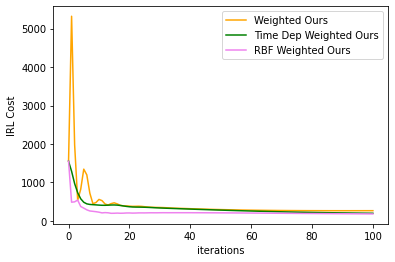

In [41]:
# IRL Cost

plt.figure()
plt.plot(weighted['irl_cost_tr'].detach(), color='orange', label="Weighted Ours")
plt.plot(timedep['irl_cost_tr'].detach(), color='green', label="Time Dep Weighted Ours")
plt.plot(rbf['irl_cost_tr'].detach(), color='violet', label="RBF Weighted Ours")
plt.xlabel("iterations")
plt.ylabel("IRL Cost")
plt.legend()

plt.savefig(f"{model_data_dir}/{data_type}_IRL_cost.png")

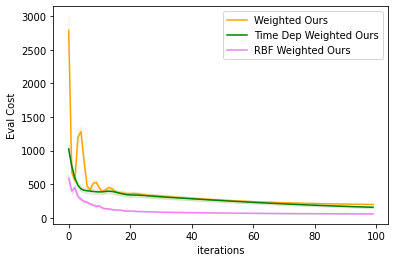

In [40]:
# Plot Evaluation

plt.figure()
weighted_trace = weighted['irl_cost_eval'].detach()
w_mean = weighted_trace.mean(dim=-1)
w_std = weighted_trace.std(dim=-1)
timedep_trace = timedep['irl_cost_eval'].detach()
t_mean = timedep_trace.mean(dim=-1)
t_std = timedep_trace.std(dim=-1)
rbf_trace = rbf['irl_cost_eval'].detach()
r_mean = rbf_trace.mean(dim=-1)
r_std = rbf_trace.std(dim=-1)
plt.plot(w_mean, color='orange', label="Weighted Ours")
plt.fill_between(np.arange(len(w_mean)), w_mean - w_std, w_mean + w_std, color='orange', alpha=0.1)
plt.plot(t_mean, color='green', label="Time Dep Weighted Ours")
plt.fill_between(np.arange(len(t_mean)), t_mean - t_std, t_mean + t_std, color='green', alpha=0.1)
plt.plot(r_mean, color='violet', label="RBF Weighted Ours")
plt.fill_between(np.arange(len(r_mean)), r_mean - r_std, r_mean + r_std, color='blueviolet', alpha=0.1)
plt.xlabel("iterations")
plt.ylabel("Eval Cost")
plt.legend()

plt.savefig(f"{model_data_dir}/{data_type}_Eval.png")
plt.show()

In [31]:
# Get All Demo Trajectories

with open(f'{traj_data_dir}/traj_data_{data_type}.pkl', 'rb') as f:
    trajs = pickle.load(f)

n_test_traj = 3
n_inner_iter = 1
train_trajs = trajs[0:1]
test_trajs = trajs[0:0 + n_test_traj]

traj_len = len(train_trajs[0]['desired_keypoints'])
time_horizon, n_keypt_dim = test_trajs[0]['desired_keypoints'].reshape(traj_len, -1).shape

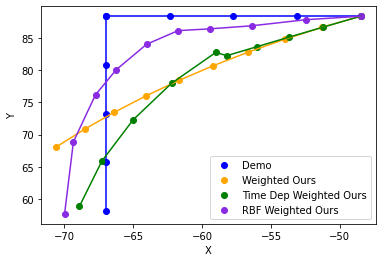

In [32]:
# Plot predicted traj during training

plt.figure()

plt.scatter(x=train_trajs[0]['desired_keypoints'][:, 0, 0], y=train_trajs[0]['desired_keypoints'][:, 0, 2],
            color='blue', label='Demo')
plt.plot(train_trajs[0]['desired_keypoints'][:, 0, 0],
         train_trajs[0]['desired_keypoints'][:, 0, 2], color='blue')

plt.scatter(x=weighted['fina_pred_traj'][:, -n_keypt_dim].detach(),
            y=weighted['fina_pred_traj'][:, -n_keypt_dim + 2].detach(), color='orange', label="Weighted Ours")
plt.plot(weighted['fina_pred_traj'][:, -n_keypt_dim].detach(),
         weighted['fina_pred_traj'][:, -n_keypt_dim + 2].detach(), color='orange')

plt.scatter(x=timedep['fina_pred_traj'][:, -n_keypt_dim].detach(),
            y=timedep['fina_pred_traj'][:, -n_keypt_dim + 2].detach(), color='green',
            label="Time Dep Weighted Ours")
plt.plot(timedep['fina_pred_traj'][:, -n_keypt_dim].detach(),
         timedep['fina_pred_traj'][:, -n_keypt_dim + 2].detach(), color='green')

plt.scatter(x=rbf['fina_pred_traj'][:, -n_keypt_dim].detach(),
            y=rbf['fina_pred_traj'][:, -n_keypt_dim + 2].detach(), color='blueviolet', label="RBF Weighted Ours")
plt.plot(rbf['fina_pred_traj'][:, -n_keypt_dim].detach(),
         rbf['fina_pred_traj'][:, -n_keypt_dim + 2].detach(), color='blueviolet')

plt.xlabel("X")
plt.ylabel("Y")
plt.legend()

plt.savefig(f"{model_data_dir}/{data_type}_pred_train_traj.png")

In [33]:
# Generate trajectories with the trained costs

w_weights = weighted["cost_parameters"]['weights']
t_weights = timedep["cost_parameters"]['weights']
r_weights = rbf["cost_parameters"]['weights_fn.weights']

rel_urdf_path = 'env/kuka_iiwa/urdf/iiwa7_ft_with_obj_keypts.urdf'
urdf_path = os.path.join(mbirl.__path__[0], rel_urdf_path)
robot_model = DifferentiableRobotModel(urdf_path=urdf_path, name="kuka_w_obj_keypts")

w_eval_losses, w_predicted_trajectories = evaluate_action_optimization(
    LearnableWeightedCost(dim=n_keypt_dim, weights=w_weights),
    robot_model=robot_model,
    irl_loss_fn=IRLLoss(dim=n_keypt_dim),
    trajs=test_trajs,
    n_inner_iter=n_inner_iter)
t_eval_losses, t_predicted_trajectories = evaluate_action_optimization(
    LearnableTimeDepWeightedCost(dim=n_keypt_dim, time_horizon=time_horizon, weights=t_weights),
    robot_model=robot_model,
    irl_loss_fn=IRLLoss(dim=n_keypt_dim),
    trajs=test_trajs,
    n_inner_iter=n_inner_iter)
r_eval_losses, r_predicted_trajectories = evaluate_action_optimization(
    LearnableRBFWeightedCost(dim=n_keypt_dim, time_horizon=time_horizon, weights=r_weights),
    robot_model=robot_model,
    irl_loss_fn=IRLLoss(dim=n_keypt_dim),
    trajs=test_trajs,
    n_inner_iter=n_inner_iter)


Unknown tag: material
Unknown tag: self_collision_checking
Unknown tag: material
Unknown tag: material
Unknown tag: material
Unknown tag: material
Unknown tag: material
Unknown tag: material
Unknown tag: material
Unknown tag: contact
Unknown tag: contact
Unknown tag: contact


Weights: Parameter containing:
tensor([[ 0.2363],
        [ 0.1000],
        [-0.0873],
        [ 0.2039],
        [ 0.1000],
        [-0.0812]], requires_grad=True)
Weights: Parameter containing:
tensor([[ 0.0100,  0.0100,  0.0100,  0.0100,  0.0100,  0.0100],
        [ 1.3284,  0.0100, -0.5043,  1.2303,  0.0100, -0.4682],
        [ 1.3350,  0.0100, -0.5288,  1.2325,  0.0100, -0.4934],
        [ 1.3342,  0.0100, -0.5467,  1.2277,  0.0100, -0.5122],
        [ 1.3267,  0.0100, -0.5586,  1.2164,  0.0100, -0.5250],
        [ 1.0676,  0.0100, -0.5839,  0.9469,  0.0100, -0.5577],
        [ 0.8389,  0.0100, -0.0296,  0.7710,  0.0100, -0.0133],
        [ 0.5688,  0.0100,  0.1652,  0.5292,  0.0100,  0.1726],
        [ 0.4347,  0.0100,  0.2801,  0.4136,  0.0100,  0.2831],
        [ 0.3784,  0.0100,  0.3480,  0.3679,  0.0100,  0.3491]],
       requires_grad=True)

RBFWEIGHTS: tensor([0.0000, 2.2500, 4.5000, 6.7500, 9.0000])
Weights: tensor([[ 0.3120,  0.0114, -0.1477,  0.2546,  0.0114, -0.1349],


torch.Size([10, 2, 3])
torch.Size([10, 2, 3])
torch.Size([10, 2, 3])


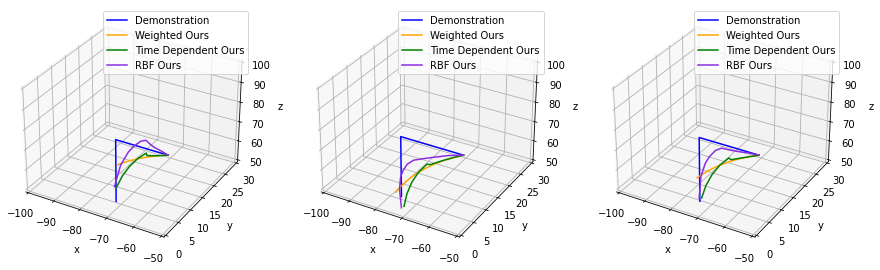

In [34]:
# Visualize Generated Trajectories in 3D

fig = plt.figure(figsize=(n_test_traj * 5, 5))
for i, traj in enumerate(test_trajs):
    traj = test_trajs[i]["desired_keypoints"].detach().numpy()
    ax = fig.add_subplot(1, n_test_traj, i + 1, projection='3d')
    print(test_trajs[i]["desired_keypoints"].shape)
    ax.plot(traj[:, 0, 0], traj[:, 0, 1],
            traj[:, 0, 2], color='blue', label='Demonstration')
    ax.plot(w_predicted_trajectories[i, :, -n_keypt_dim], w_predicted_trajectories[i, :, -n_keypt_dim + 1],
            w_predicted_trajectories[i, :, -n_keypt_dim + 2], color='orange', label='Weighted Ours')
    ax.plot(t_predicted_trajectories[i, :, -n_keypt_dim], t_predicted_trajectories[i, :, -n_keypt_dim + 1],
            t_predicted_trajectories[i, :, -n_keypt_dim + 2], color='green', label='Time Dependent Ours')
    ax.plot(r_predicted_trajectories[i, :, -n_keypt_dim], r_predicted_trajectories[i, :, -n_keypt_dim + 1],
            r_predicted_trajectories[i, :, -n_keypt_dim + 2], color='blueviolet', label='RBF Ours')
    min_x = -100.0;
    max_x = -50.0
    min_y = 0.0;
    max_y = 30
    min_z = 50;
    max_z = 100
    ax.set_xlim([min_x, max_x])
    ax.set_ylim([min_y, max_y])
    ax.set_zlim([min_z, max_z])
    ax.set_xlabel("x")
    ax.set_ylabel("y")
    ax.set_zlabel("z")
    ax.legend()
plt.savefig(f"{model_data_dir}/{data_type}_pred_eval_traj_3d.png")

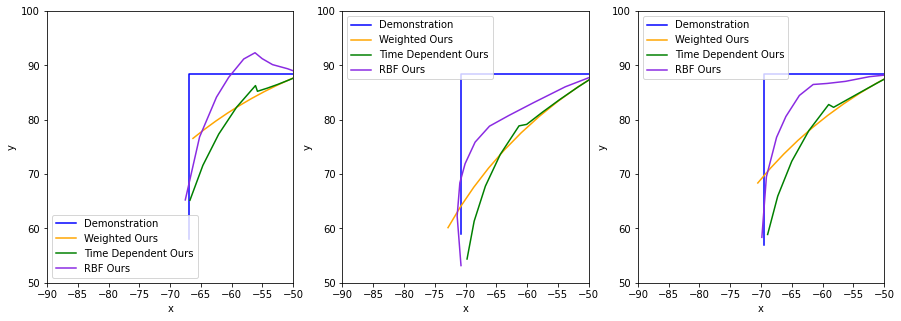

In [35]:
# Visualize Generated Trajectories in 2D

fig = plt.figure(figsize=(n_test_traj * 5, 5))
for i, traj in enumerate(test_trajs):
    traj = test_trajs[i]["desired_keypoints"].detach().numpy()
    ax = fig.add_subplot(1, n_test_traj, i + 1)
    ax.plot(traj[:, 0, 0], traj[:, 0, 2], color='blue', label='Demonstration')
    ax.plot(w_predicted_trajectories[i, :, -n_keypt_dim], w_predicted_trajectories[i, :, -n_keypt_dim + 2], color='orange', label='Weighted Ours')
    ax.plot(t_predicted_trajectories[i, :, -n_keypt_dim], t_predicted_trajectories[i, :, -n_keypt_dim + 2], color='green', label='Time Dependent Ours')
    ax.plot(r_predicted_trajectories[i, :, -n_keypt_dim], r_predicted_trajectories[i, :, -n_keypt_dim + 2], color='blueviolet', label='RBF Ours')
    min_x = -90.0;
    max_x = -50.0
    min_z = 50;
    max_z = 100
    ax.set_xlim([min_x, max_x])
    ax.set_ylim([min_z, max_z])
    ax.set_xlabel("x")
    ax.set_ylabel("y")
    ax.legend()
plt.savefig(f"{model_data_dir}/{data_type}_pred_eval_traj_2d.png")